In [1]:
import pandas
import datetime
import os
import numpy
from scipy import signal, ndimage
from davitpy.models import *
from davitpy import utils
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
import seaborn as sns
%matplotlib inline

In [2]:
selDT = datetime.datetime( 2011, 4, 9, 8, 40 )
medFiltedSize = ( 1, 3 )
fileDtStr = selDT.strftime("%y%m%d")
# Load the appropriate file based on date
baseDir = "../data/"
for root, dirs, files in os.walk(baseDir):
    for fName in files:
        if fName.find(fileDtStr) != -1:
            inpTecFile = root + "/" + fName

In [3]:
dataDF = pandas.read_hdf(inpTecFile, 'Data/Table Layout')
dataDF["date"] = pandas.to_datetime(dataDF["year"]*10000000000 +\
                                    dataDF["month"]*100000000 + dataDF["day"]*1000000 +\
                                    dataDF["hour"]*10000 + dataDF["min"]*100 +\
                                    dataDF["sec"],format='%Y%m%d%H%M%S')
# Only take selected datetime
dataDF["selTimeDel"] = dataDF["date"] - selDT
dataDF = dataDF[ dataDF["selTimeDel"] == min(abs(dataDF["selTimeDel"])) ].reset_index(drop=True)
# Discard tec values which are 2stds away!
cutOffLimit = dataDF["tec"].mean() + 2*dataDF["tec"].std()
dataDF = dataDF[ dataDF["tec"] <= cutOffLimit ]
dataDF.head()

,year,month,day,hour,min,sec,ut1_unix,ut2_unix,recno,gdlat,glon,tec,dtec,date,selTimeDel
0,2011,4,9,8,42,30,1302338400,1302338700,210,-90.0,-3.0,4.2,2.6,2011-04-09 08:42:30,00:02:30
1,2011,4,9,8,42,30,1302338400,1302338700,210,-90.0,-2.0,4.4,2.6,2011-04-09 08:42:30,00:02:30
2,2011,4,9,8,42,30,1302338400,1302338700,210,-90.0,-1.0,4.3,2.5,2011-04-09 08:42:30,00:02:30
3,2011,4,9,8,42,30,1302338400,1302338700,210,-90.0,0.0,4.1,2.5,2011-04-09 08:42:30,00:02:30
4,2011,4,9,8,42,30,1302338400,1302338700,210,-90.0,1.0,3.9,2.5,2011-04-09 08:42:30,00:02:30


In [4]:
medDF = dataDF.pivot( index="gdlat", columns="glon", values="tec" )
filteredTecArr = signal.medfilt( medDF.as_matrix(), kernel_size=medFiltedSize )
medDF[ medDF.columns ] = filteredTecArr
medDF = medDF.unstack().reset_index()
medDF.columns = [ "glon", "gdlat", "med_tec" ]

In [5]:
gLonArr = medDF["glon"].values
gdLatArr = medDF["gdlat"].values
mlon, mlat = utils.coord_conv( gLonArr, gdLatArr, \
                                 "geo", "mag", altitude=300., \
                                 date_time=selDT )
medDF["mlon"] = mlon
medDF["mlat"] = mlat
medDF["mlt"] = [ aacgm.mltFromYmdhms(selDT.year, \
                selDT.month,selDT.day, selDT.hour,\
                selDT.minute, selDT.second, x) for x in medDF["mlon"] ]
medDF["normMLT"] = [x-24 if x >= 12\
             else x for x in medDF['mlt']]
medDF.head()

,glon,gdlat,med_tec,mlon,mlat,mlt,normMLT
0,-180.0,-90.0,NaN,18.472788,-74.917784,5.001458,5.001458
1,-180.0,-89.0,NaN,15.508806,-75.451646,4.803859,4.803859
2,-180.0,-88.0,NaN,12.294946,-75.948940,4.589602,4.589602
3,-180.0,-87.0,NaN,8.823391,-76.403395,4.358165,4.358165
4,-180.0,-86.0,NaN,5.092981,-76.808426,4.109471,4.109471


/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


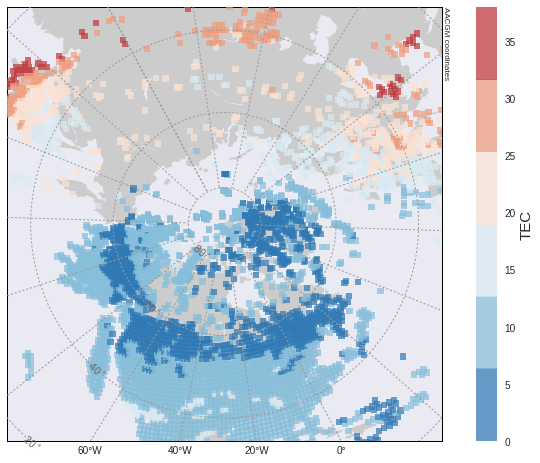

In [6]:
# set colorbar
seaMap = ListedColormap(sns.color_palette("RdBu_r"))
# Plot map
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
m1 = utils.plotUtils.mapObj(boundinglat=30., gridLabels=True, coords='mag', ax=ax, datetime=selDT)
xVec, yVec = m1(list(medDF["mlon"]), list(medDF["mlat"]), coords="mag")
tecPlot = m1.scatter( xVec, yVec , c=medDF["med_tec"], s=40.,\
           cmap=seaMap, alpha=0.7, zorder=5., \
                     edgecolor='none', marker="s" )

cbar = plt.colorbar(tecPlot, orientation='vertical')
cbar.set_label('TEC', size=15)
f.savefig("../figs/tec-med-filt-" + selDT.strftime("%Y%m%d-%H%M") + ".pdf",bbox_inches='tight')